# Propensity Score Matching

In [25]:
#Import basic libariaries
%matplotlib inline
import math
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from causalinference import CausalModel

Data from: 
"Propensity Score Matching Methods for Non-Experimental Causal Studies," Review of Economics and Statistics, Vol. 84, (February 2002), pp. 151-161.
Goal: Find the effect of training on Earnings

The variables from left to right are: treatment indicator (1 if treated, 0 if not treated), age, education, Black (1 if black, 0 otherwise), Hispanic (1 if Hispanic, 0 otherwise), married (1 if married, 0 otherwise), nodegree (1 if no degree, 0 otherwise), RE74 (earnings in 1974), RE75 (earnings in 1975), and RE78 (earnings in 1978).

In [15]:
control_1=pd.read_stata('cps_controls.dta')
control_1.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,CPS1,0.0,45.0,11.0,0.0,0.0,1.0,1.0,21516.669922,25243.550781,25564.669922
1,CPS1,0.0,21.0,14.0,0.0,0.0,0.0,0.0,3175.970947,5852.564941,13496.080078
2,CPS1,0.0,38.0,12.0,0.0,0.0,1.0,0.0,23039.019531,25130.759766,25564.669922
3,CPS1,0.0,48.0,6.0,0.0,0.0,1.0,1.0,24994.369141,25243.550781,25564.669922
4,CPS1,0.0,18.0,8.0,0.0,0.0,1.0,1.0,1669.295044,10727.610352,9860.869141


In [16]:
control_2=pd.read_stata('psid_controls.dta')
control_2.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,PSID,0.0,47.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,PSID,0.0,50.0,12.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,PSID,0.0,44.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,PSID,0.0,28.0,12.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,PSID,0.0,54.0,12.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [17]:
control_1.columns=['ID','Treated', 'Age', 'Education', 'Black', 'Hispanic', 'Married',
         'Nodegree', 'RE74', 'RE75', 'RE78']
control_2.columns=['ID','Treated', 'Age', 'Education', 'Black', 'Hispanic', 'Married',
         'Nodegree', 'RE74', 'RE75', 'RE78']

In [18]:
#Load the data
names = ['Treated', 'Age', 'Education', 'Black', 'Hispanic', 'Married',
         'Nodegree', 'RE74', 'RE75', 'RE78']
treated = pd.read_table('nswre74_treated.txt', sep = '\s+',
                        header = None, names = names)
treated['ID']="nswre74"

In [19]:
treated.head()

,Treated,Age,Education,Black,Hispanic,Married,Nodegree,RE74,RE75,RE78,ID
0,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.0460,nswre74
1,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.8940,nswre74
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.4500,nswre74
3,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.1460,nswre74
4,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.7899,nswre74


In [20]:
data = pd.concat([treated, control_1,control_2],sort=True)

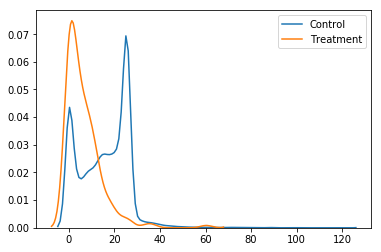

In [21]:
data[['RE74_div', 'RE75_div', 'RE78_div']] = data[['RE74', 'RE75', 'RE78']] / 1000


sns.kdeplot(data[data.Treated == 0].RE78_div, label='Control')
sns.kdeplot(data[data.Treated == 1].RE78_div, label='Treatment')

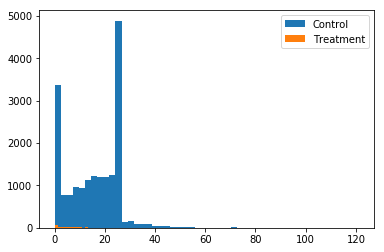

In [22]:
plt.hist(data[data.Treated == 0].RE78_div, label='Control', bins=50);
plt.hist(data[data.Treated == 1].RE78_div, label='Treatment', bins=50);
plt.legend();

In [26]:
causal_model = CausalModel(
    X=data[['Age', 'Education', 'Black', 'Hispanic', 'Married','Nodegree', 'RE74_div', 'RE75_div']].values,
    D=data.Treated.values,
    Y=data.RE78_div.values
)
causal_model.est_propensity()  #estimates propensity score
causal_model.trim_s()          #trims data based on propensity score
causal_model.stratify_s()      #Stratifies the sample based on propensity .
                
causal_model.est_via_ols()      #Estimates average treatment effects using least squares.
causal_model.est_via_matching(bias_adj=True) #Estimates average treatment effects using nearest- neighborhood matching.
causal_model.est_via_weighting() #Estimates average treatment effects using doubly-robust version of the Horvitz-Thompson weighting estimator.

print(causal_model.summary_stats)
print(causal_model.estimates)
print(causal_model.propensity)
print(causal_model.strata)

C:\Users\Acer\Anaconda2\lib\site-packages\causalinference\core\summary.py:110: RuntimeWarning: invalid value encountered in true_divide
  return (mean_t-mean_c) / np.sqrt((sd_c**2+sd_t**2)/2)
C:\Users\Acer\Anaconda2\lib\site-packages\causalinference\estimators\ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]



Summary Statistics

                       Controls (N_c=531)         Treated (N_t=151)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        4.984        7.957        6.021        7.957        1.037

                       Controls (N_c=531)         Treated (N_t=151)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       28.175       11.837       25.728        7.344       -0.248
             X1       10.458        2.802       10.238        2.061       -0.089
             X2        0.902        0.297        0.967        0.180        0.264
             X3        0.098        0.297        0.033        0.180       -0.264
             X4        0.303        0.460        0.139        0.347       -0.403
      

C:\Users\Acer\Anaconda2\lib\site-packages\causalinference\estimators\matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef
C:\Users\Acer\Anaconda2\lib\site-packages\causalinference\estimators\weighting.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  wlscoef = np.linalg.lstsq(Z_w, Y_w)[0]


3 methods for the treatment effect estimation were used:
--ols estimates average treatment effects using least squares.
--matching estimates average treatment effects using nearest- neighborhood matching.
--weighting estimates average treatment effects using doubly-robust version of the Horvitz-Thompson weighting estimator.

3 of them give positive ATE (average treatment effect), 
meaning that the treatment has a positive effect on the target (revenue), 
though only one (weighting) is significant
the summary statistics also shows that controls mean of Y is lower than the mean of treated group

for the propensity score calculation only the variables x2-x5, x7 were siginificant.

    